---
## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import auc

In [4]:
train = pd.read_csv('./../Data/training_dataset.csv')
test = pd.read_csv('./../Data/validation_set.csv')


---
## Data Exploration

In [5]:
train.head()

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  object 
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  object 
 6   pinjaman_rumah                22916 non-null  object 
 7   pinjaman_pribadi              22916 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [7]:
def check_anomali(df):
    print('Shape Data')
    print(df.shape)
    print('-'*10)
    print()
    print('Missing Value : ')
    print(df.isna().mean()*100)
    print('-'*10)
    print()
    print('Data Duplicated : ')
    print(df.duplicated().sum())

In [8]:
check_anomali(train)

Shape Data
(22916, 22)
----------

Missing Value : 
customer_number                 0.0
usia                            0.0
pekerjaan                       0.0
status_perkawinan               0.0
pendidikan                      0.0
gagal_bayar_sebelumnya          0.0
pinjaman_rumah                  0.0
pinjaman_pribadi                0.0
jenis_kontak                    0.0
bulan_kontak_terakhir           0.0
hari_kontak_terakhir            0.0
jumlah_kontak_kampanye_ini      0.0
hari_sejak_kontak_sebelumnya    0.0
jumlah_kontak_sebelumnya        0.0
hasil_kampanye_sebelumnya       0.0
tingkat_variasi_pekerjaan       0.0
indeks_harga_konsumen           0.0
indeks_kepercayaan_konsumen     0.0
suku_bunga_euribor_3bln         0.0
jumlah_pekerja                  0.0
pulau                           0.0
berlangganan_deposito           0.0
dtype: float64
----------

Data Duplicated : 
0


In [9]:
check_anomali(test)

Shape Data
(5729, 21)
----------

Missing Value : 
customer_number                 0.0
usia                            0.0
pekerjaan                       0.0
status_perkawinan               0.0
pendidikan                      0.0
gagal_bayar_sebelumnya          0.0
pinjaman_rumah                  0.0
pinjaman_pribadi                0.0
jenis_kontak                    0.0
bulan_kontak_terakhir           0.0
hari_kontak_terakhir            0.0
jumlah_kontak_kampanye_ini      0.0
hari_sejak_kontak_sebelumnya    0.0
jumlah_kontak_sebelumnya        0.0
hasil_kampanye_sebelumnya       0.0
tingkat_variasi_pekerjaan       0.0
indeks_harga_konsumen           0.0
indeks_kepercayaan_konsumen     0.0
suku_bunga_euribor_3bln         0.0
jumlah_pekerja                  0.0
pulau                           0.0
dtype: float64
----------

Data Duplicated : 
0


In [10]:
train.describe()

,customer_number,usia,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,berlangganan_deposito
count,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000
mean,550930.993193,40.016233,2.561878,962.210377,0.170143,0.077915,93.576541,-40.485717,3.617890,5166.773124,0.114069
std,259909.889175,10.438059,2.794178,187.566774,0.490611,1.576176,0.580586,4.641091,1.737591,72.479698,0.317902
min,100108.000000,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,325755.000000,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,553139.000000,38.000000,2.000000,999.000000,0.000000,1.100000,93.876000,-41.800000,4.857000,5191.000000,0.000000
75%,777157.500000,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,999997.000000,98.000000,42.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


---
## EDA

In [11]:
train.head()

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


In [12]:
cat_cols_train = train.select_dtypes(include=['object', 'category'])
num_cols_train = train.select_dtypes(include='number')

cat_cols_test = test.select_dtypes(include=['object', 'category'])
num_cols_test = test.select_dtypes(include='number')

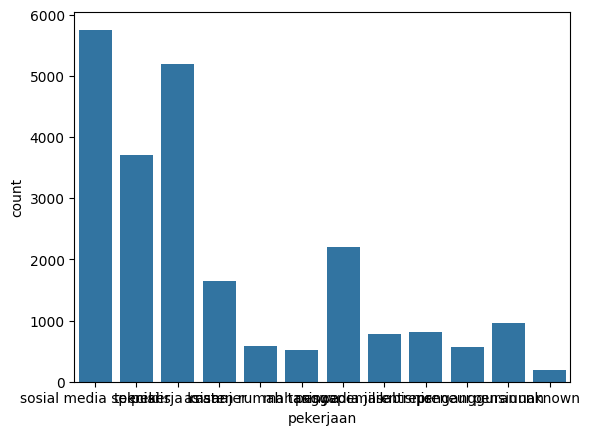

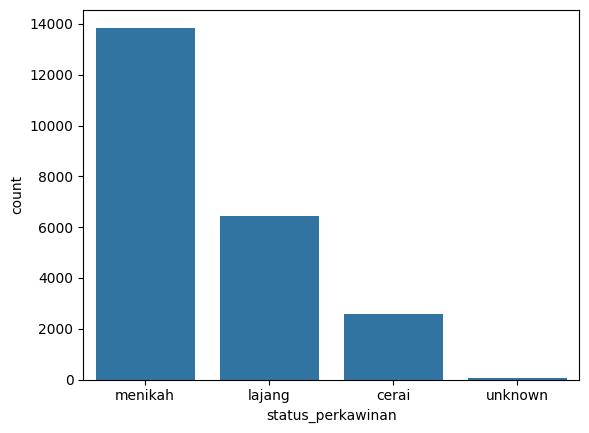

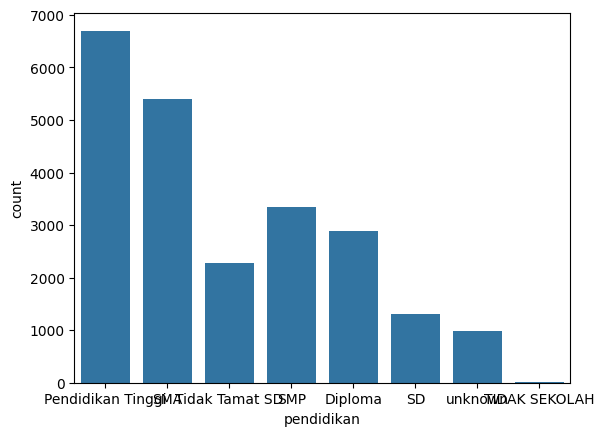

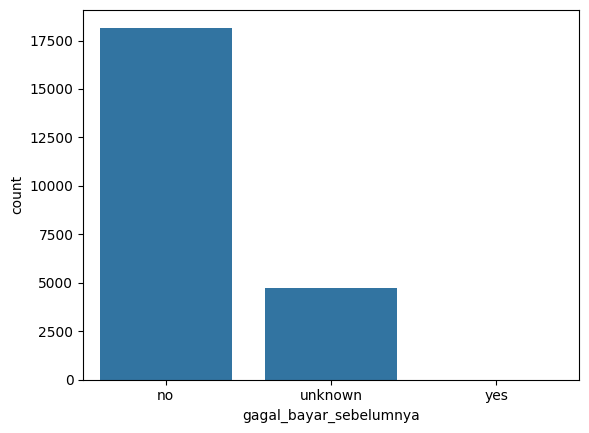

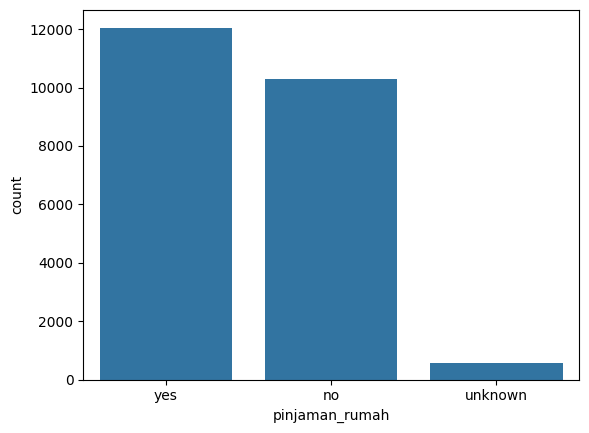

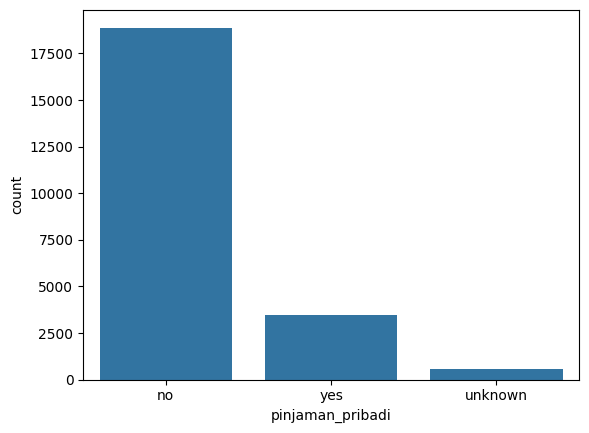

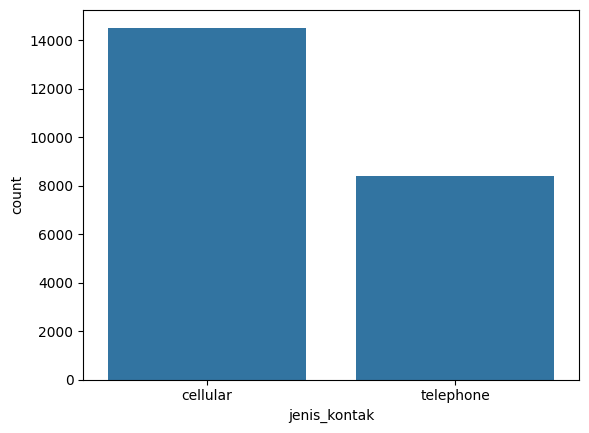

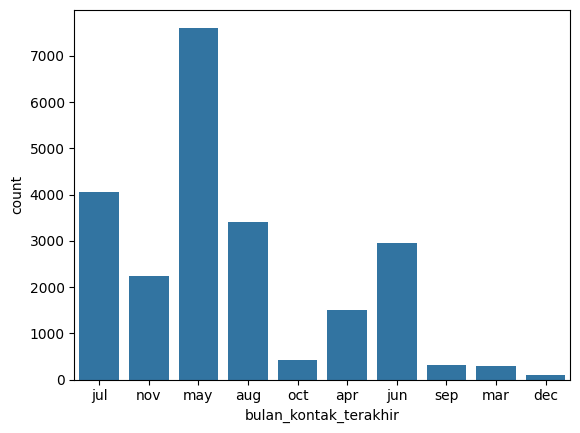

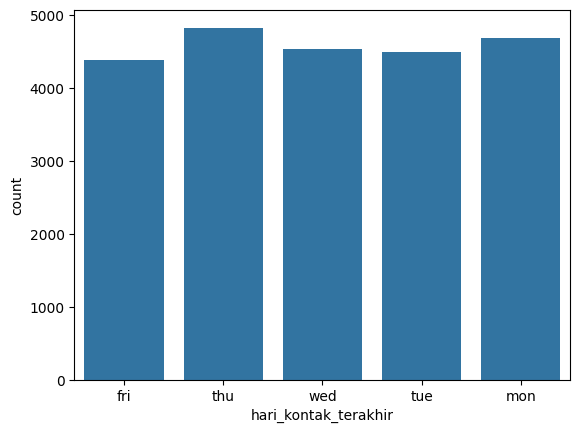

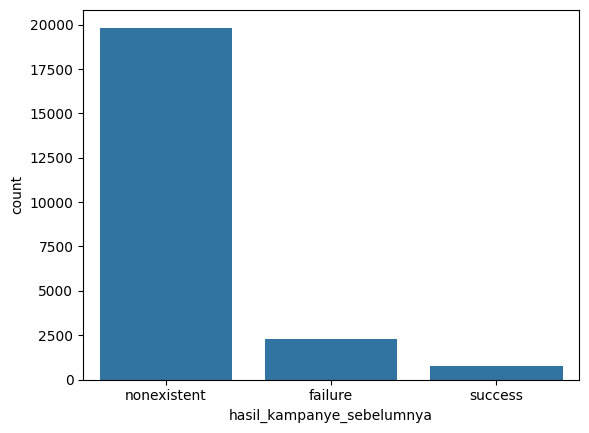

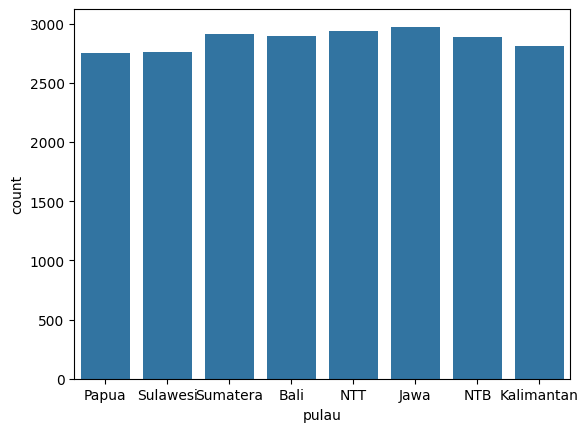

In [13]:
#visualization of categorical data
for col in cat_cols_train:
    sns.countplot(x=col, data=train)
    plt.show()

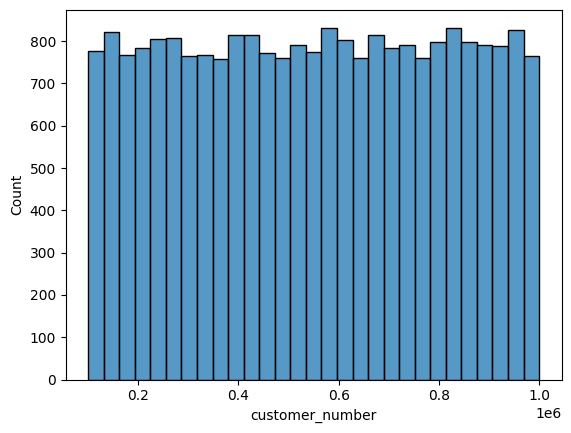

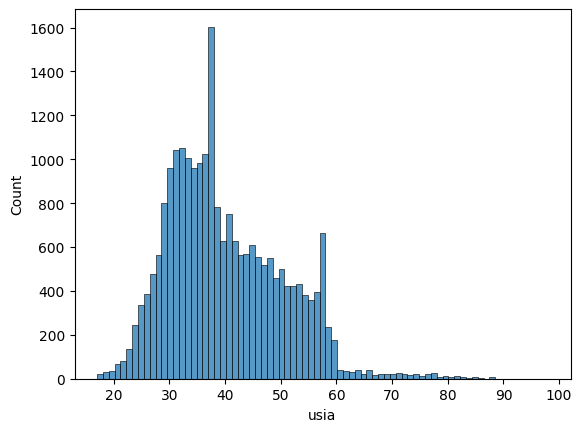

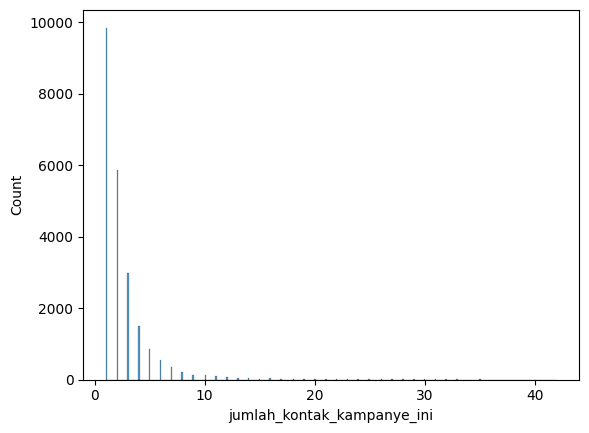

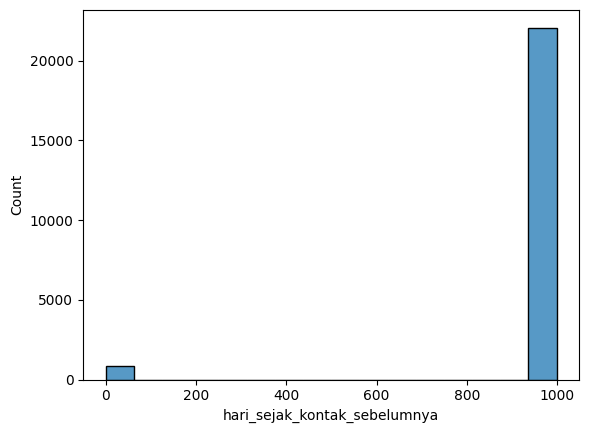

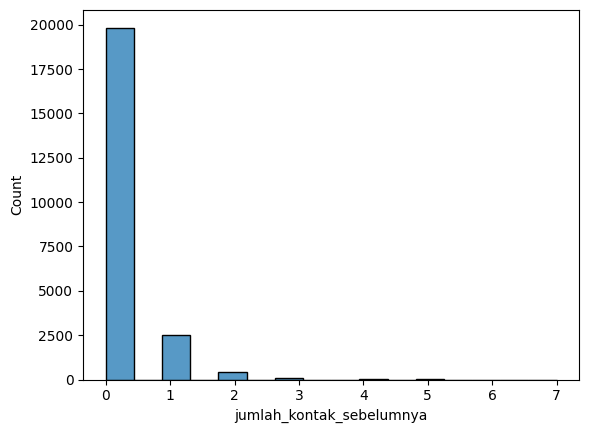

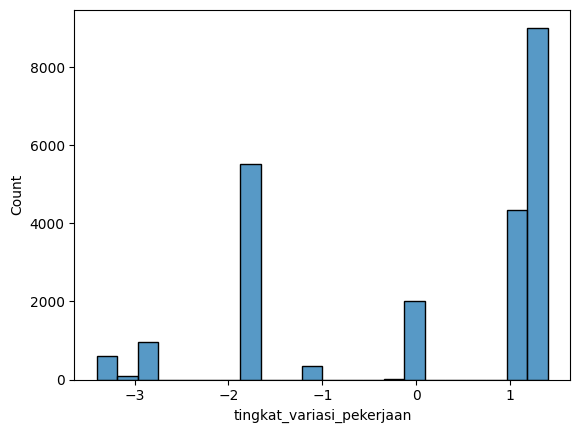

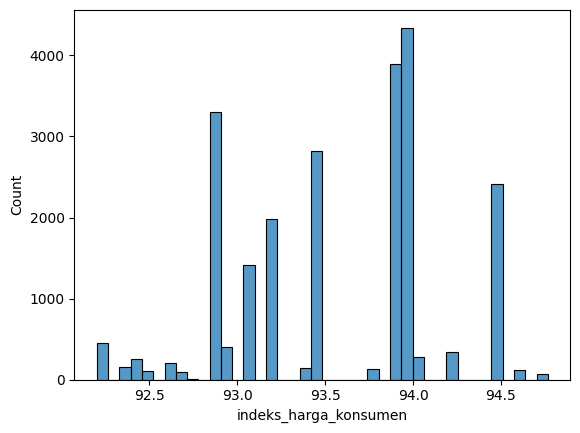

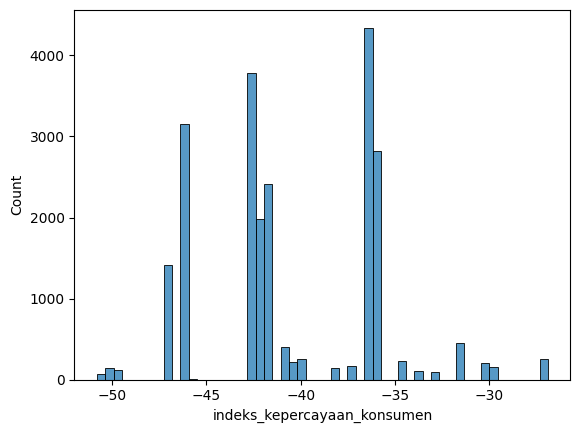

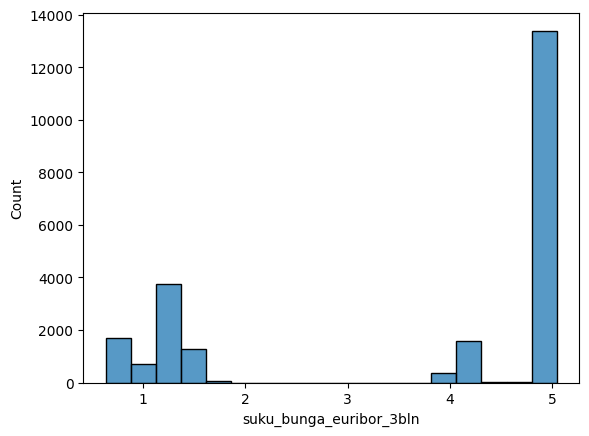

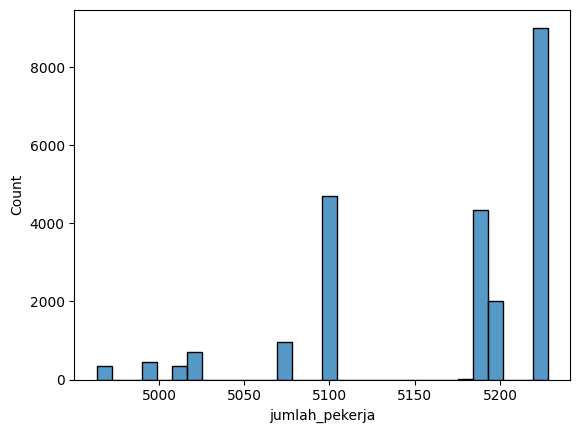

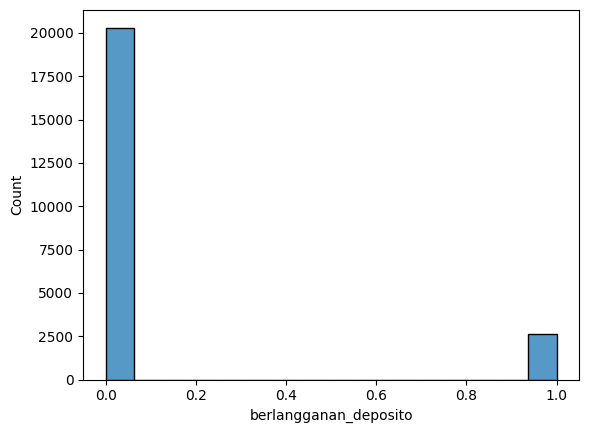

In [14]:
#visualization of numerical data
for col in num_cols_train:
    sns.histplot(x=col, data=train)
    plt.show()

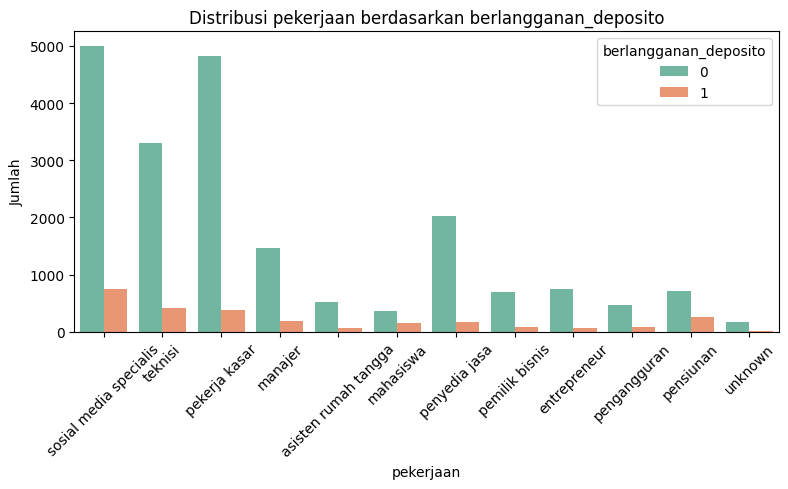

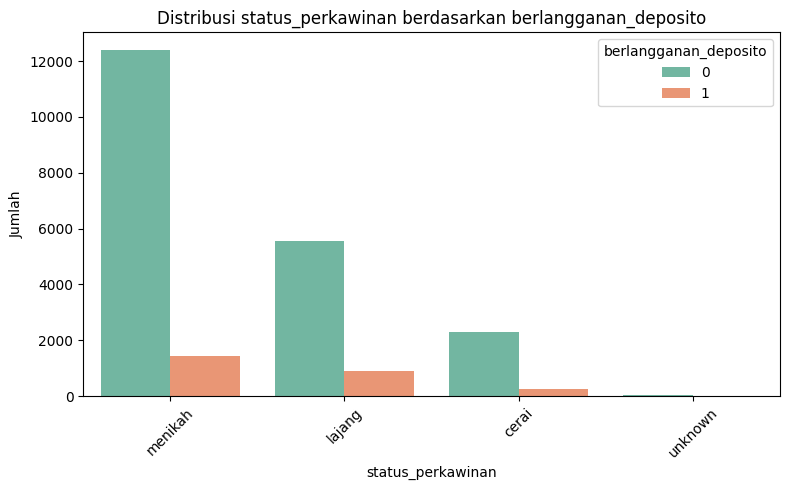

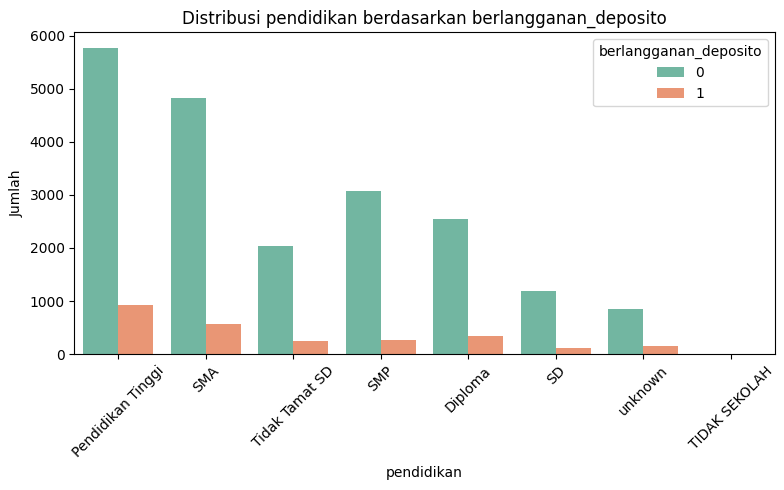

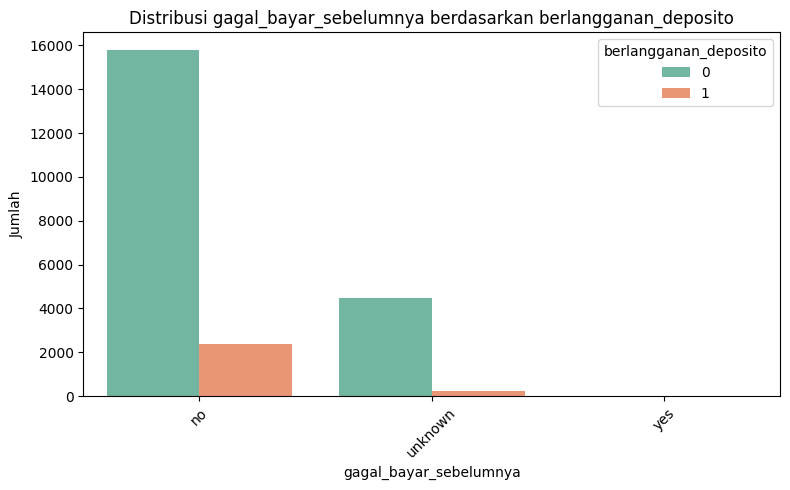

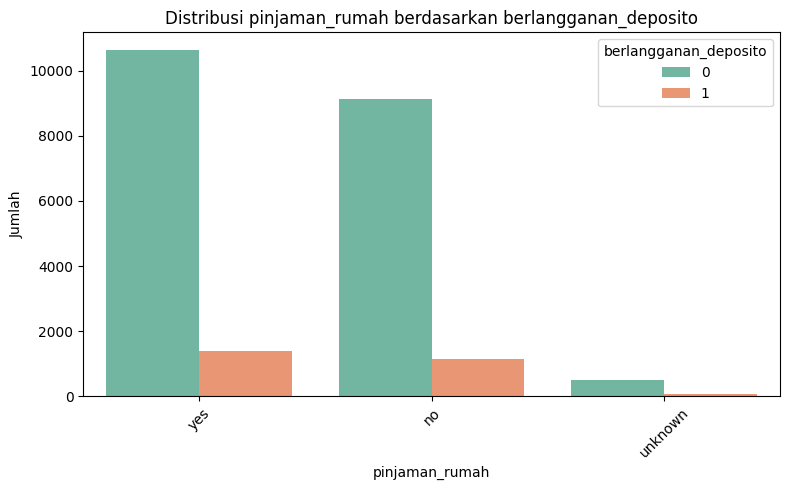

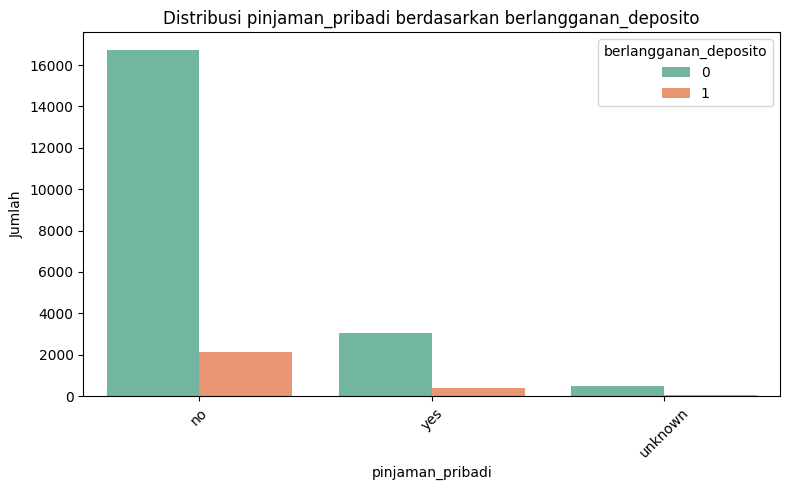

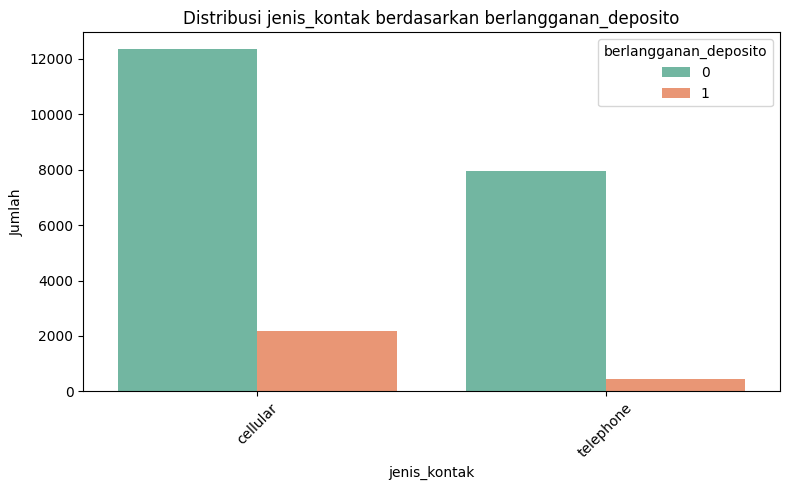

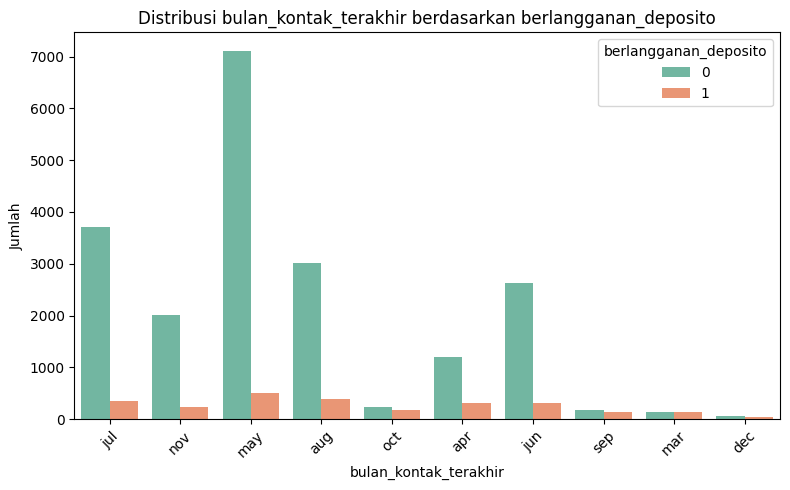

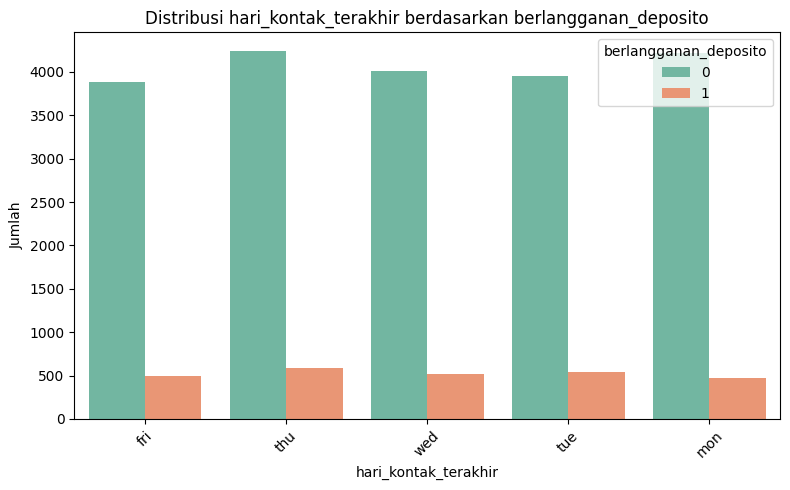

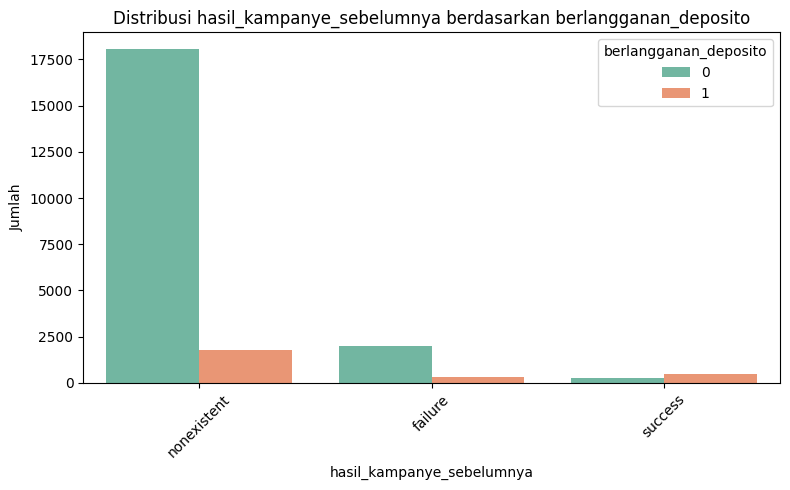

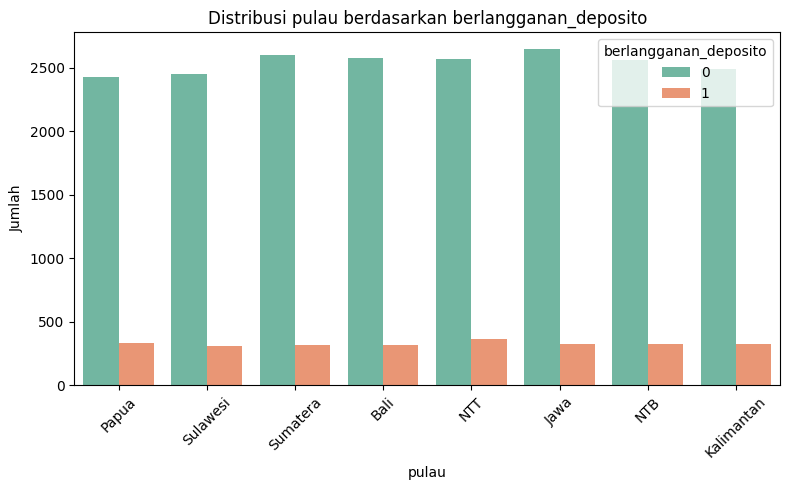

In [15]:
def plot_categorical_distribution(df, categorical_cols, target_col):
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col, hue=target_col, palette='Set2')
        plt.title(f'Distribusi {col} berdasarkan {target_col}')
        plt.xlabel(col)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Contoh pemanggilan (pastikan target_col adalah string, bukan Series)
plot_categorical_distribution(train, cat_cols_train, 'berlangganan_deposito')


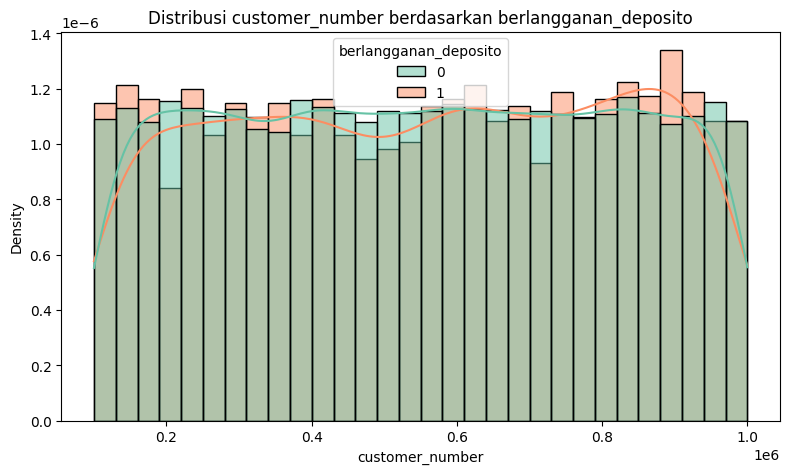

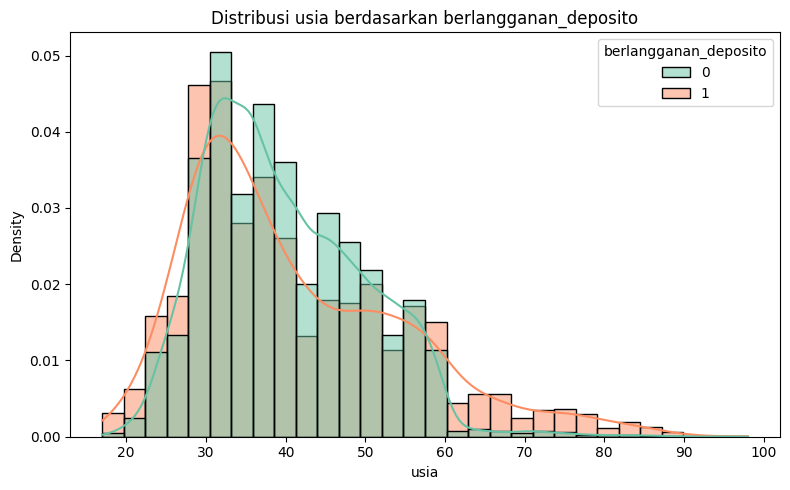

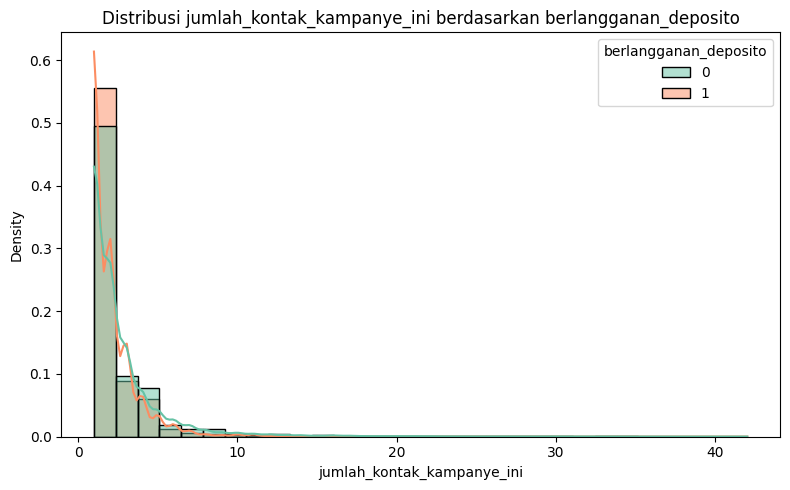

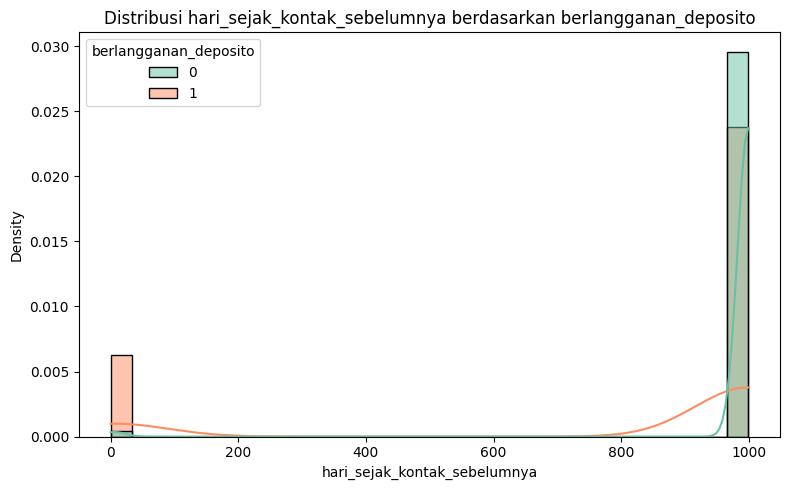

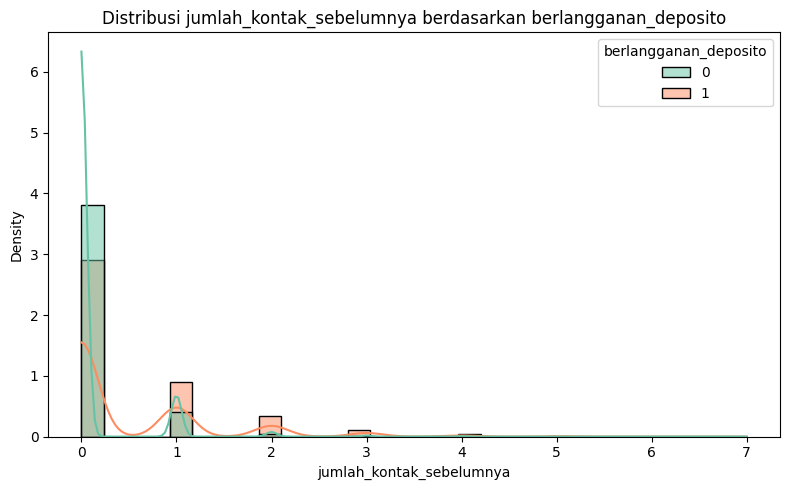

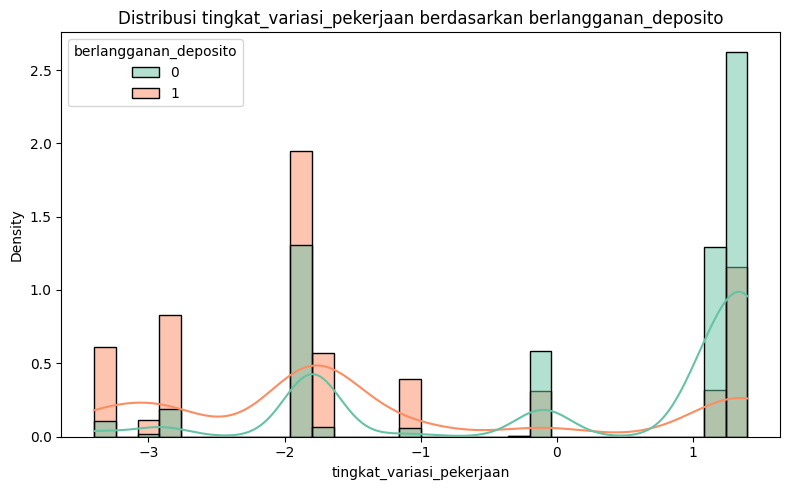

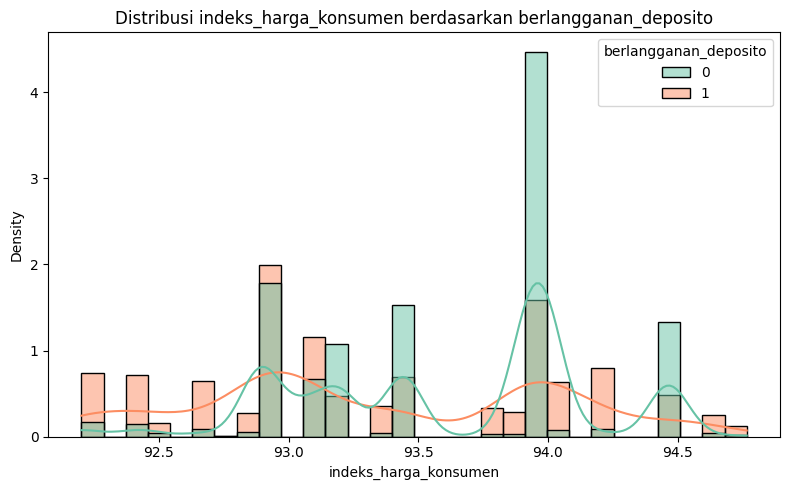

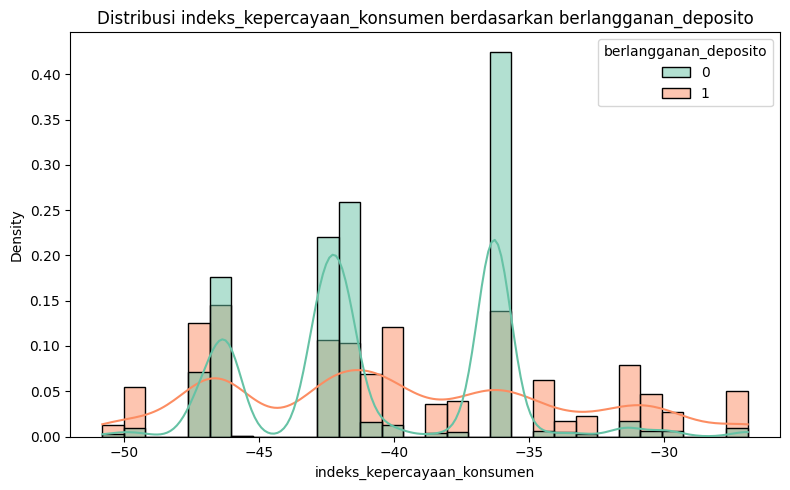

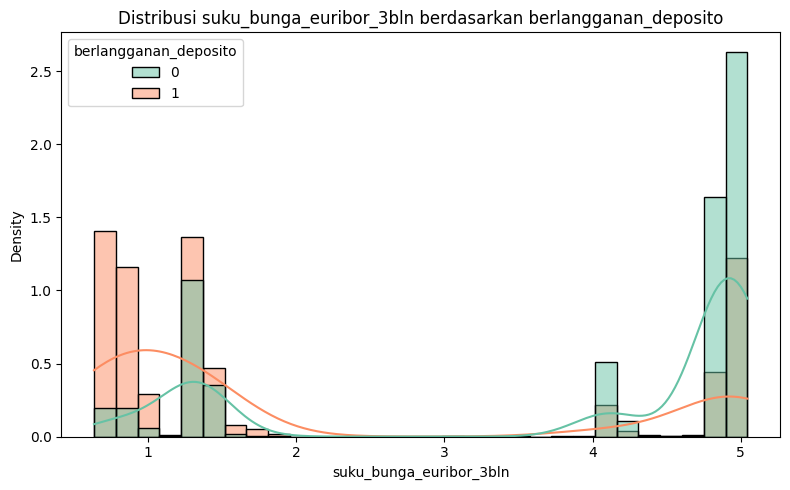

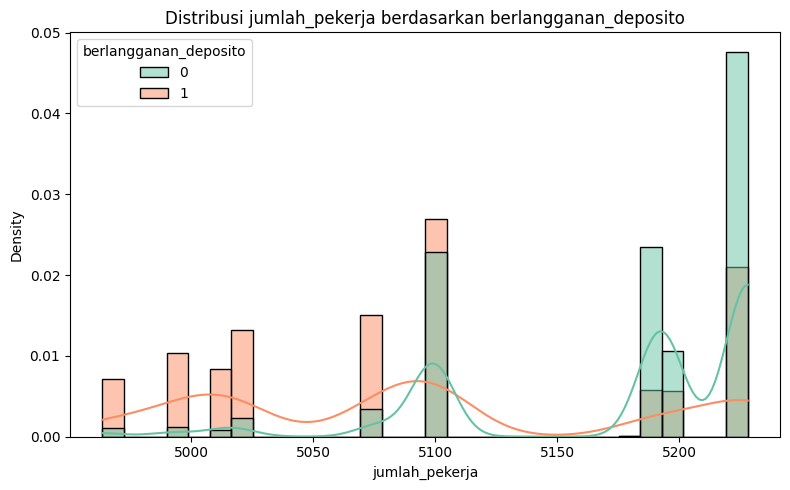

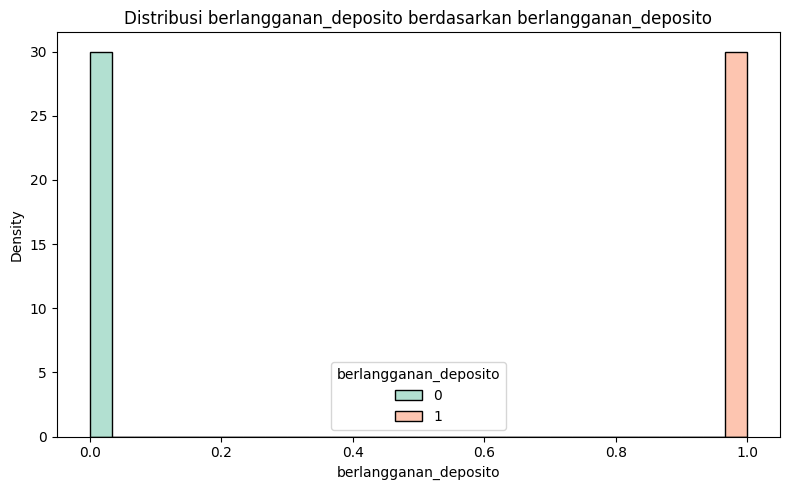

In [16]:
def plot_histplots(df, num_cols, target_col, bins=30):
    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=df, x=col, hue=target_col, bins=bins, kde=True, stat="density", common_norm=False, palette='Set2')
        plt.title(f'Distribusi {col} berdasarkan {target_col}')
        plt.tight_layout()
        plt.show()


plot_histplots(train, num_cols_train, 'berlangganan_deposito')

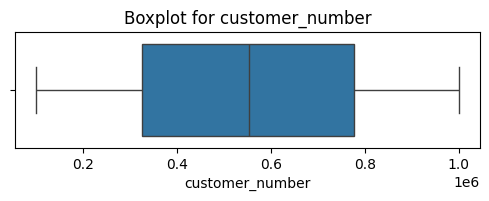

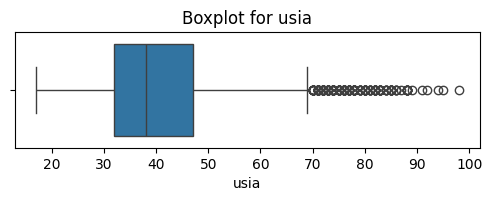

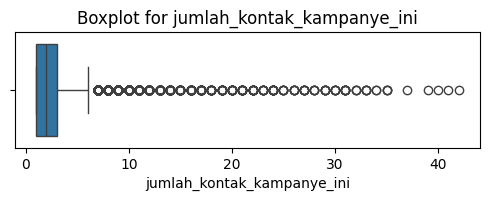

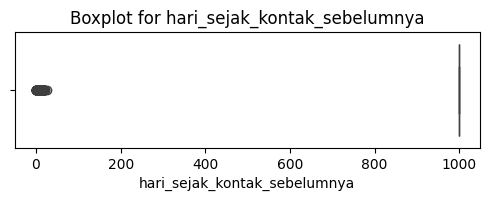

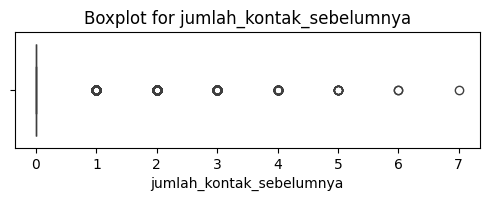

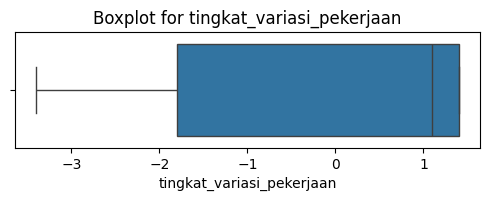

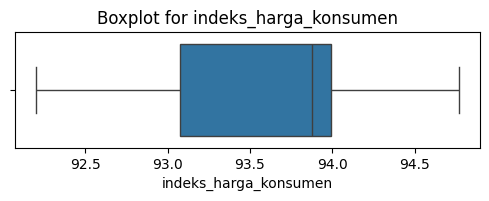

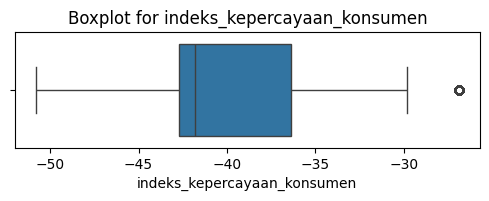

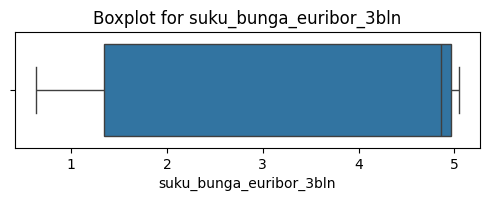

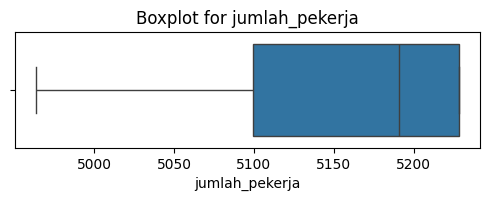

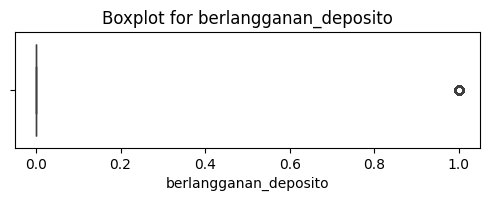

In [18]:
num_cols = train.select_dtypes(include=np.number).columns


for col in num_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot for {col}')
    plt.show()


In [19]:
def find_single_target_categories(df, cat_cols, target_col):
    for col in cat_cols:
        grouped = df.groupby(col)[target_col].nunique()
        single_target = grouped[grouped == 1]
        if not single_target.empty:
            print(f'\n[!] Kolom "{col}" punya kategori yang hanya mengandung satu kelas target:')
            for category in single_target.index:
                unique_target = df[df[col] == category][target_col].unique()[0]
                print(f'  - {category}: hanya ada target "{unique_target}"')

find_single_target_categories(train, cat_cols_train, 'berlangganan_deposito')


[!] Kolom "gagal_bayar_sebelumnya" punya kategori yang hanya mengandung satu kelas target:
  - yes: hanya ada target "0"


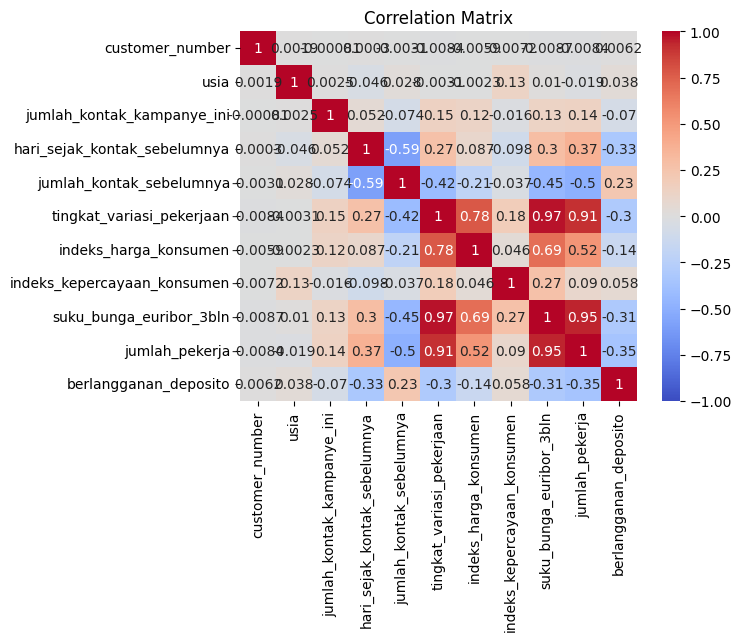

In [20]:
#heatmap correlation numerical
corr_matrix = train[num_cols_train.columns.tolist()].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(train[num_cols_train.columns.tolist()])

# Hitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data["Fitur"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                           Fitur            VIF
0                          const  529739.614517
1                customer_number       1.000245
2                           usia       1.020656
3     jumlah_kontak_kampanye_ini       1.031095
4   hari_sejak_kontak_sebelumnya       1.687910
5       jumlah_kontak_sebelumnya       1.799355
6      tingkat_variasi_pekerjaan      33.493595
7          indeks_harga_konsumen       6.444646
8    indeks_kepercayaan_konsumen       2.660561
9        suku_bunga_euribor_3bln      64.977754
10                jumlah_pekerja      31.645374
11         berlangganan_deposito       1.216804


In [19]:
constant_features = [col for col in train.columns if train[col].nunique() == 1]

print(f"Constant features ({len(constant_features)}):")
print(constant_features)

Constant features (0):
[]


In [20]:
# Fitur quasi-constant: mayoritas nilainya sama (default threshold = 0.99)
threshold = 0.96
quasi_constant_features = []

for col in train.columns:
    top_freq = train[col].value_counts(normalize=True).values[0]
    if top_freq >= threshold:
        quasi_constant_features.append(col)

print(f"Quasi-constant features ({len(quasi_constant_features)}):")
print(quasi_constant_features)

Quasi-constant features (1):
['hari_sejak_kontak_sebelumnya']


---
## Engineering

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['suku_bunga_euribor_3bln', 'tingkat_variasi_pekerjaan', 'jumlah_pekerja']
X_scaled_train = StandardScaler().fit_transform(train[features])
X_scaled_test = StandardScaler().fit_transform(test[features])

pca = PCA(n_components=1)
train['komponen_makro'] = pca.fit_transform(X_scaled_train)
test['komponen_makro'] = pca.transform(X_scaled_test) 

In [22]:
train.drop(['suku_bunga_euribor_3bln', 'tingkat_variasi_pekerjaan', 'jumlah_pekerja','hari_sejak_kontak_sebelumnya'], axis=1, inplace=True)
test.drop(['suku_bunga_euribor_3bln', 'tingkat_variasi_pekerjaan', 'jumlah_pekerja','hari_sejak_kontak_sebelumnya'], axis=1, inplace=True)

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures

def brute_force_feature_engineering(df, target_col):
    df = df.copy()

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target_col)
    cat_cols = df.select_dtypes(include=['object']).columns

    # 1. Transformasi numerik: kuadrat, akar, log (jika > 0)
    for col in num_cols:
        df[f'{col}_squared'] = df[col] ** 2
        df[f'{col}_sqrt'] = np.sqrt(np.abs(df[col]))
        # log cuma buat >0
        df[f'{col}_log'] = np.log1p(df[col].clip(lower=0))

    # 2. Interaksi antar numerik (pairwise product)
    for i, col1 in enumerate(num_cols):
        for col2 in num_cols[i+1:]:
            df[f'{col1}_x_{col2}'] = df[col1] * df[col2]

    # 3. Bin numerik (discretize)
    binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    for col in num_cols:
        df[f'{col}_binned'] = binner.fit_transform(df[[col]]).astype(int)

    # 4. Count encoding untuk kategori
    for col in cat_cols:
        counts = df[col].value_counts()
        df[f'{col}_countenc'] = df[col].map(counts)

    # 5. Target encoding (bisa pake mean target per kategori)
    for col in cat_cols:
        target_means = df.groupby(col)[target_col].mean()
        df[f'{col}_targetenc'] = df[col].map(target_means)

    return df

# Misal kamu punya dataframe df dan target 'berlangganan_deposito'
df_new = brute_force_feature_engineering(train, target_col='berlangganan_deposito')

In [24]:
check_anomali(df_new)

Shape Data
(22916, 90)
----------

Missing Value : 
customer_number                        0.0
usia                                   0.0
pekerjaan                              0.0
status_perkawinan                      0.0
pendidikan                             0.0
                                      ... 
jenis_kontak_targetenc                 0.0
bulan_kontak_terakhir_targetenc        0.0
hari_kontak_terakhir_targetenc         0.0
hasil_kampanye_sebelumnya_targetenc    0.0
pulau_targetenc                        0.0
Length: 90, dtype: float64
----------

Data Duplicated : 
0


---
## Model

#### Pake Random Search

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np
# Prepare data
X = df_new.drop('berlangganan_deposito', axis=1)
y = df_new['berlangganan_deposito']


In [26]:
# Hitung proporsi kelas dulu
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

In [27]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.utils import shuffle

# ========== 1. Custom ROC AUC Scorer ==========
def safe_roc_auc(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        return 0.5  # jika hanya ada 1 kelas dalam fold

roc_auc_safe = make_scorer(safe_roc_auc, needs_proba=True)

# ========== 2. CatBoost Wrapper ==========
class CatBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, iterations=100, depth=6, learning_rate=0.1, l2_leaf_reg=3, border_count=32,
                 bagging_temperature=1, random_strength=1, cat_features=None, class_weights=None):
        self.iterations = iterations
        self.depth = depth
        self.learning_rate = learning_rate
        self.l2_leaf_reg = l2_leaf_reg
        self.border_count = border_count
        self.bagging_temperature = bagging_temperature
        self.random_strength = random_strength
        self.cat_features = cat_features
        self.class_weights = class_weights
        self.model = None
        
    def fit(self, X, y):
        self.model = CatBoostClassifier(
            iterations=self.iterations,
            depth=self.depth,
            learning_rate=self.learning_rate,
            l2_leaf_reg=self.l2_leaf_reg,
            border_count=self.border_count,
            bagging_temperature=self.bagging_temperature,
            random_strength=self.random_strength,
            cat_features=self.cat_features,
            class_weights=self.class_weights,
            verbose=False
        )
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

# ========== 3. Data Preparation ==========
# Pastikan data tidak ada missing values
X = df_new.drop(columns='berlangganan_deposito')
y = df_new['berlangganan_deposito']

# Bersihkan NaN
X = X.fillna("NA") if X.select_dtypes(include='object').shape[1] > 0 else X.fillna(0)

# Tentukan kolom kategori
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Class weights manual jika perlu (opsional)
class_weights = [1, len(y) / (2 * y.value_counts()[1])]

# Shuffle data agar stratifikasi lebih baik
X, y = shuffle(X, y, random_state=42)

# ========== 4. CV Split Check (Debug Fold) ==========
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1} Class Distribution:\n{pd.Series(y.iloc[val_idx]).value_counts()}\n")

# ========== 5. Parameter Grid ==========
param_dist_cbc = {
    'iterations': np.arange(100, 1001, 100),
    'depth': np.arange(4, 11),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1, 2],
    'random_strength': [1, 2, 5, 10]
}

# ========== 6. Randomized Search CV ==========
cbc_wrap = CatBoostWrapper(cat_features=cat_features, class_weights=class_weights)

rs_cbc = RandomizedSearchCV(
    cbc_wrap,
    param_distributions=param_dist_cbc,
    n_iter=20,
    scoring=roc_auc_safe,
    cv=skf,
    random_state=42,
    verbose=1,
    n_jobs=-1,
)

rs_cbc.fit(X, y)

# ========== 7. Output Best Model ==========
print("[CatBoost] Best Params:", rs_cbc.best_params_)
print("[CatBoost] Best AUC:", rs_cbc.best_score_)


Fold 1 Class Distribution:
berlangganan_deposito
0    4061
1     523
Name: count, dtype: int64

Fold 2 Class Distribution:
berlangganan_deposito
0    4061
1     522
Name: count, dtype: int64

Fold 3 Class Distribution:
berlangganan_deposito
0    4060
1     523
Name: count, dtype: int64

Fold 4 Class Distribution:
berlangganan_deposito
0    4060
1     523
Name: count, dtype: int64

Fold 5 Class Distribution:
berlangganan_deposito
0    4060
1     523
Name: count, dtype: int64

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CatBoost] Best Params: {'random_strength': 5, 'learning_rate': 0.3, 'l2_leaf_reg': 7, 'iterations': 1000, 'depth': 8, 'border_count': 128, 'bagging_temperature': 1}
[CatBoost] Best AUC: nan


In [28]:
a

NameError: name 'a' is not defined

In [ ]:
test['Predicted_Vehicle_Revenue_Hours'] = best_model.predict(test)

In [ ]:
sample_submission['Vehicle Revenue Hours (Target)'] = test['Predicted_Vehicle_Revenue_Hours']
sample_submission.to_csv('./../Submission/rf_rs_s.csv', index=False)

In [ ]:
import joblib
joblib.dump(best_model, './../Model/best_rf_model.pkl',compress=3)

['./../Model/best_rf_model.pkl']